In [1]:
import os
os.chdir('../code')

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from utils.viz import plot_mask_on_img

In [3]:
root_ds = '../dataset'
img_size_ori = 101

# Prepair

1. Copy and extract dataset to `root_ds` (if needed)
2. Fold split

In [ ]:
# 2
# from data.functional import generate_fold
# generate_fold('../dataset', 5, '../dataset/folds.csv')

# Data Exploration

Let's look at some data. We can see that TGS chose to use very varied data by inspecting. That is great and adresses a problem in deep learning geoscience at the moment. We build models on one type of seismic and have no idea whether it generalizes.

/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


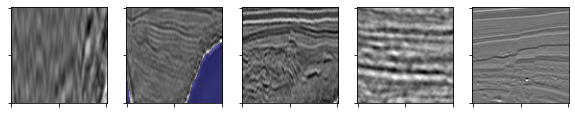

In [4]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
fig, axs = plt.subplots(1, len(ids), figsize=(10, 10))
for j, img_name in enumerate(ids):
    img = Image.open(os.path.join(root_ds, 'train/images/' + img_name + '.png'))
    mask = np.array(Image.open(os.path.join(root_ds, 'train/masks/' + img_name + '.png')), dtype=np.uint8)
    mask = mask > 1
    plot_mask_on_img(axs[j], img, mask)
plt.show()

## Load DF

In [5]:
# train_df = pd.read_csv(os.path.join(root_ds, "train.csv"), index_col="id", usecols=[0])
depths_df = pd.read_csv(os.path.join(root_ds, "depths.csv"), index_col="id")
# train_df = train_df.join(depths_df)
train_df = pd.read_csv(os.path.join(root_ds, 'folds.csv'), index_col="id")
# train_df = train_df.merge(folds, on='id')
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [6]:
train_df.head(5)

,z,fold,unique_pixels
id,,,
1c0b2ceb2f,71,0,1
16bee00afc,409,3,214
e82162c83c,884,3,240
97e78a5448,694,1,211
2edf2e3e05,439,3,135


In [7]:
train_df["images"] = [np.array(Image.open(os.path.join(root_ds, "train/images/{}.png".format(idx))), dtype=np.uint8) / 255 for idx in tqdm(train_df.index)]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [8]:
train_df["masks"] = [np.array(Image.open(os.path.join(root_ds, "train/masks/{}.png".format(idx))), dtype=np.uint8) / 255 for idx in tqdm(train_df.index)]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [9]:
train_df["coverage"] = train_df.masks.map(lambda x: np.sum(x) / pow(img_size_ori, 2))

In [10]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [11]:
def plot_coverage(df, suptitle="Salt coverage"):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    sns.histplot(df.coverage, kde=False, ax=axs[0])
    sns.histplot(df.coverage_class, bins=10, kde=False, ax=axs[1])
    plt.suptitle(suptitle)
    axs[0].set_xlabel("Coverage")
    axs[1].set_xlabel("Coverage class")
    axs[2].scatter(df.coverage, df.coverage_class)
    axs[2].set_xlabel("Coverage")
    axs[2].set_ylabel("Coverage class")

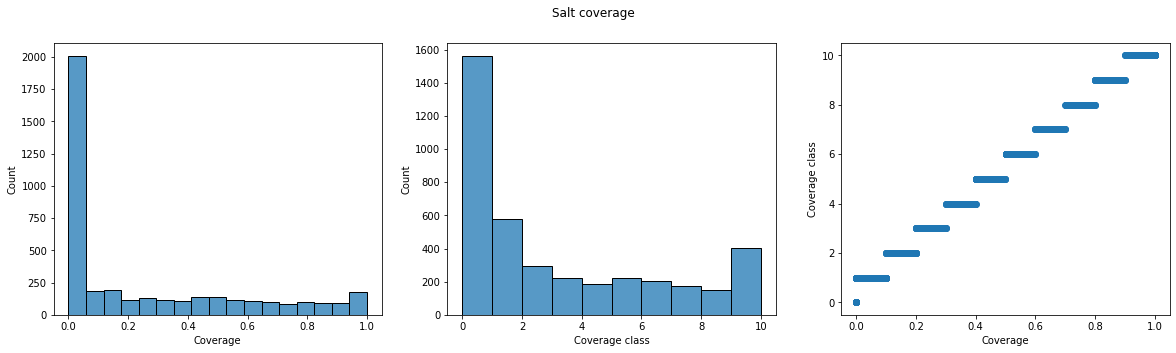

In [12]:
plot_coverage(train_df)

Text(0.5, 0.98, 'Depth distribution')

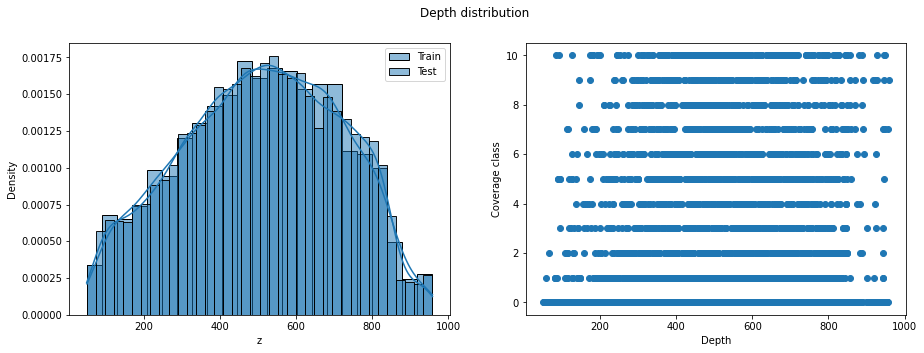

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(train_df.z, label="Train", kde=True, stat='density', ax=axs[0])
sns.histplot(test_df.z, label="Test", kde=True, stat='density', ax=axs[0])
axs[0].legend()

axs[1].scatter(train_df.z, train_df.coverage_class)
axs[1].set_xlabel("Depth")
axs[1].set_ylabel("Coverage class")

plt.suptitle("Depth distribution")

## Show some example images

In [14]:
train_df = train_df.sort_values('z').reset_index()

In [15]:
def plot_images(start, step, max_images=60):
    grid_width = 10
    grid_height = int(max_images / grid_width)
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))
    for i in range(max_images):
        idx = i * step + start
        img = train_df.loc[idx].images
        mask = train_df.loc[idx].masks > 0
        ax = axs[int(i / grid_width), i % grid_width]
        plot_mask_on_img(ax, img, mask, train_df.loc[idx])
    plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


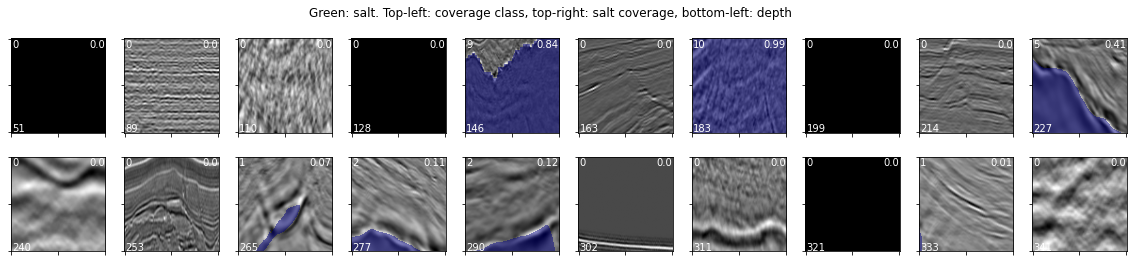

In [16]:
plot_images(0, 50, 20)

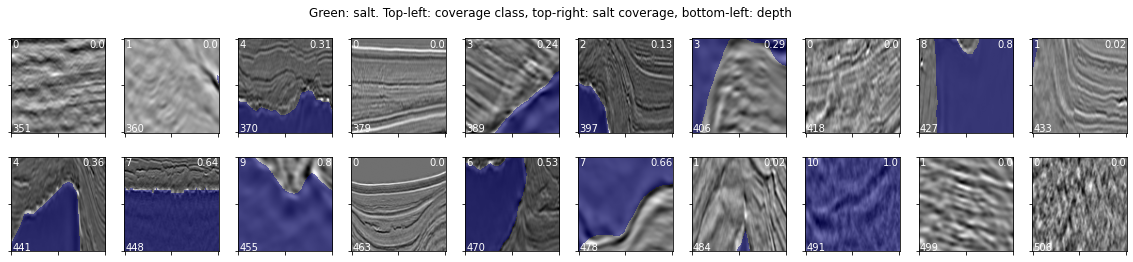

In [17]:
plot_images(1000, 50, 20)

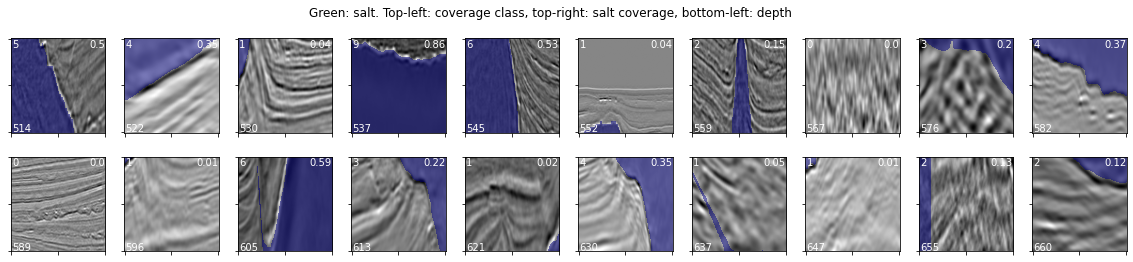

In [18]:
plot_images(2000, 50, 20)

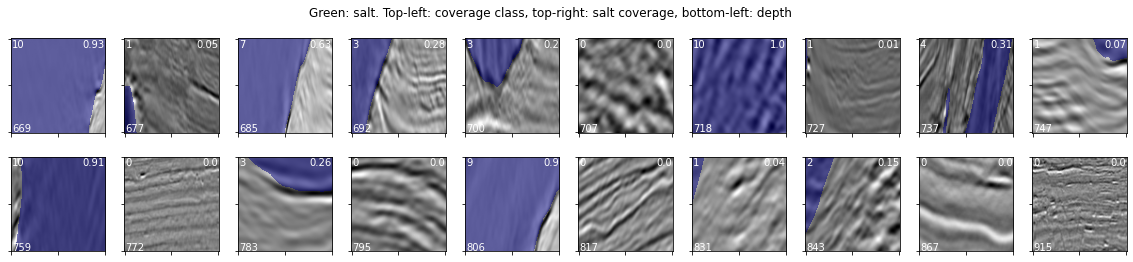

In [19]:
plot_images(3000, 50, 20)

# Fold Stats

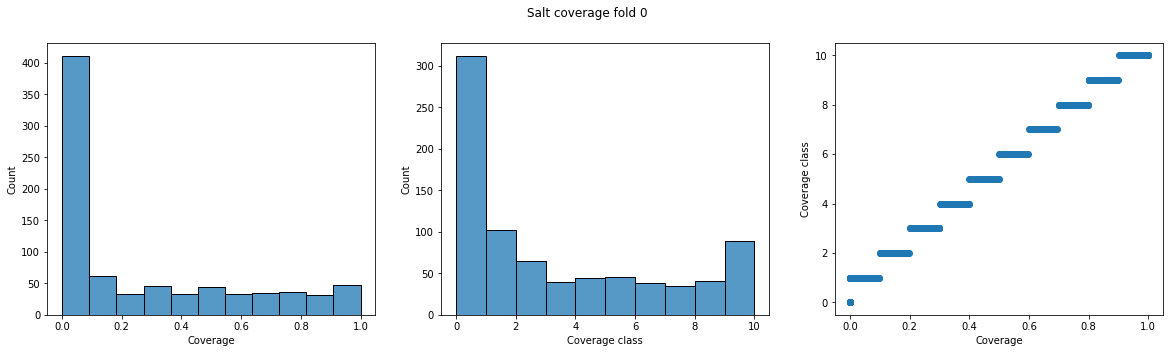

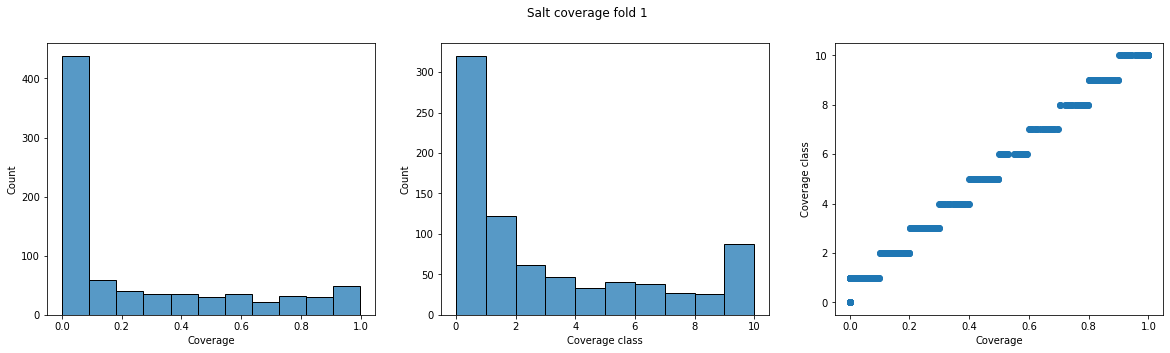

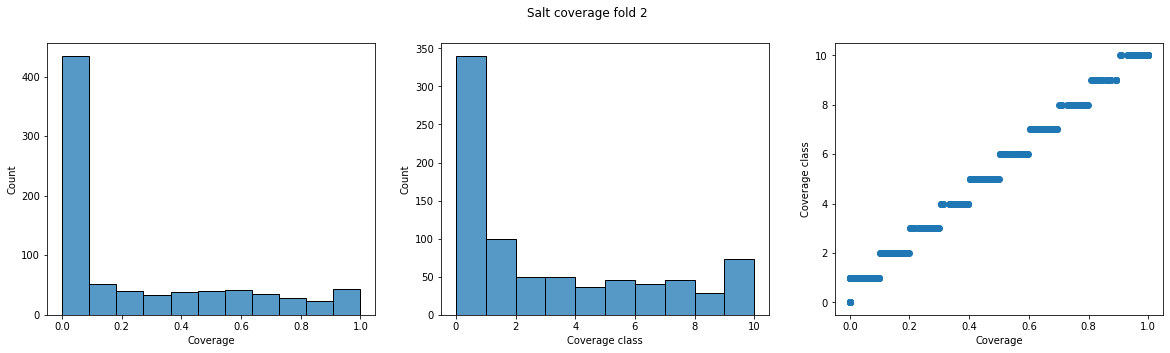

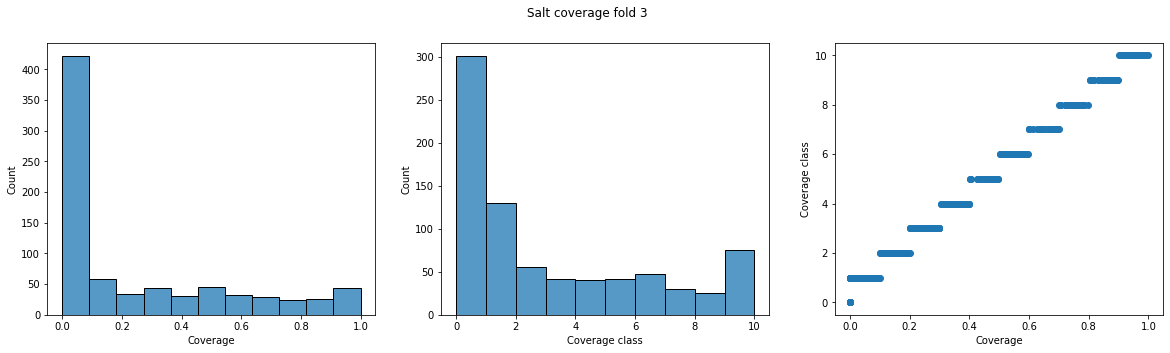

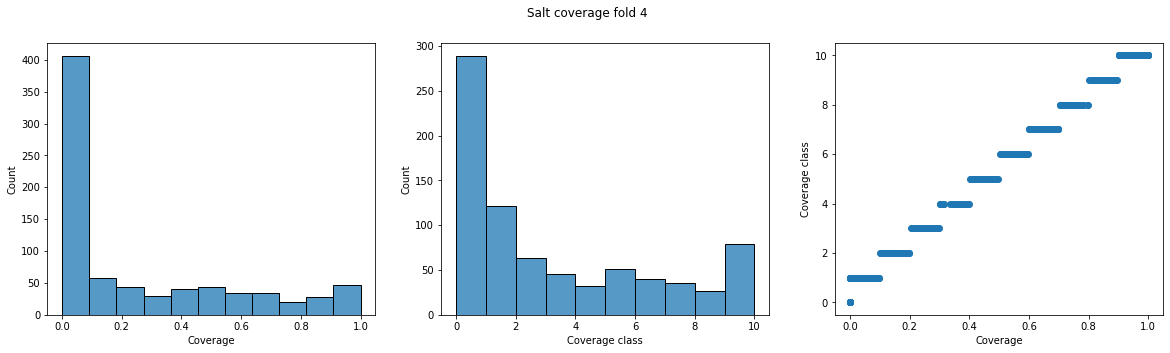

In [20]:
plot_coverage(train_df.loc[train_df.fold==0], suptitle='Salt coverage fold 0')
plot_coverage(train_df.loc[train_df.fold==1], suptitle='Salt coverage fold 1')
plot_coverage(train_df.loc[train_df.fold==2], suptitle='Salt coverage fold 2')
plot_coverage(train_df.loc[train_df.fold==3], suptitle='Salt coverage fold 3')
plot_coverage(train_df.loc[train_df.fold==4], suptitle='Salt coverage fold 4')